In [91]:
import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
import seaborn as sns
import re
from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import wordnet
import random

sns.set_style('whitegrid')

In [92]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dayvison\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dayvison\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [93]:
dataset = datasets.load_dataset("okite97/news-data")

Using custom data configuration okite97--news-data-40e98cfd881f0955
Found cached dataset csv (C:/Users/Dayvison/.cache/huggingface/datasets/okite97___csv/okite97--news-data-40e98cfd881f0955/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/2 [00:00<?, ?it/s]

In [94]:
train = dataset['train'].to_pandas()
test = dataset['test'].to_pandas()

In [95]:
train.isnull().sum()

Title       1
Excerpt     0
Category    0
dtype: int64

In [96]:
test.isnull().sum()

Title       0
Excerpt     0
Category    0
dtype: int64

In [97]:
train = train.dropna(subset=['Title']).reset_index()

In [98]:
stop_words = nltk.corpus.stopwords.words('english')

In [99]:
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") 
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line)
    
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]

    return clean_line

In [100]:
def get_vocab(corpus):
    vocab = []
    
    for frase in corpus:
        words = frase.split()
        
        for word in words:
            vocab.append(word)
  
    return vocab

In [101]:
train['Joined'] = train['Title'].str.cat(train['Excerpt'], sep =" ")
test['Joined'] = test['Title'].str.cat(test['Excerpt'], sep =" ")

train['Joined'] = train['Joined'].apply(lambda x: get_only_chars(x))
test['Joined'] = test['Joined'].apply(lambda x: get_only_chars(x))

train['Joined'] = train['Joined'].apply(lambda x: " ".join([y for y in x.split() if y not in stop_words]  ))
test['Joined'] = test['Joined'].apply(lambda x: " ".join([y for y in x.split() if y not in stop_words] ) )
    

train['Excerpt'] = train['Excerpt'].apply(lambda x: get_only_chars(x))
test['Excerpt'] = test['Excerpt'].apply(lambda x: get_only_chars(x))

train['Excerpt'] = train['Excerpt'].apply(lambda x: " ".join([y for y in x.split() if y not in stop_words]  ))
test['Excerpt'] = test['Excerpt'].apply(lambda x: " ".join([y for y in x.split() if y not in stop_words] ) )

<AxesSubplot:xlabel='Category', ylabel='count'>

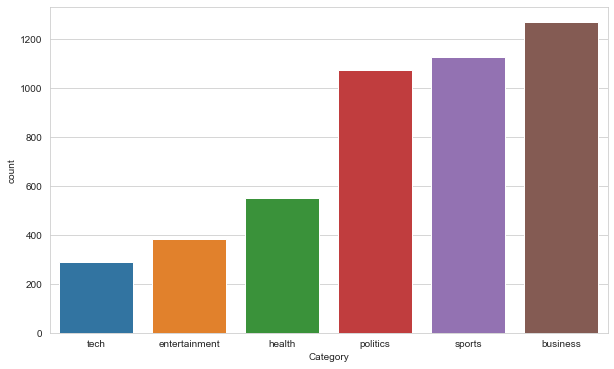

In [102]:
plt.figure(figsize=(10,6))
sns.countplot(x='Category', data=train, order=train['Category'].value_counts(ascending=True).index)

In [103]:
class_names = ['business', 'entertainment', 'health', 'politics','sports', 'tech']

In [104]:
one = OneHotEncoder(sparse=False)
y_train = one.fit_transform(train['Category'].values.reshape(-1,1))
y_test = one.transform(test['Category'].values.reshape(-1,1))

In [105]:
y_train.shape

(4685, 6)

In [106]:
y_test.shape

(828, 6)

In [107]:
len(max(train['Excerpt']))

85

In [108]:
def nn_with_embs(column='Excerpt', epochs=10, batch_size=16, h=0.01):
    
    vectorize_layer = keras.layers.TextVectorization(max_tokens=15000, output_mode='int', output_sequence_length=len(max(train[column])))
    vocab = get_vocab(train[column])
    vectorize_layer.adapt(np.unique(vocab)) 

    model = keras.models.Sequential([
        vectorize_layer,
        keras.layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=32, mask_zero=True),
    # keras.layers.Flatten(),

        keras.layers.LSTM(16, activation='relu',kernel_regularizer=keras.regularizers.L2(h), return_sequences=True),
        keras.layers.LSTM(8, activation='relu', kernel_regularizer=keras.regularizers.L2(h)),
    
        keras.layers.Dense(y_train.shape[1], activation='softmax')
    ])
  
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

    model.summary()

    history = model.fit(train[column], y_train, epochs=epochs, batch_size=batch_size, validation_data=(test[column], y_test))
  
    print(" ")
    print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(test[column]), axis=1) ,  target_names=class_names))
    print(" ")

    plt.figure(figsize=(12,6))
    plt.title('Loss and Acc')
    plt.plot(history.history['loss'], color='darkred', label='Loss')
    plt.plot(history.history['val_loss'], color='green', label='Val_Loss')
    plt.legend()

In [109]:
def nn_vectorizer(vectorizer=CountVectorizer, column='Excerpt' ,embeddings=False, epochs=10, batch_size=16, h=0.01):
    
    if embeddings:
        nn_with_embs(column, epochs, batch_size, h)
   
    else:
        vect = vectorizer()
        text_train = vect.fit_transform(train[column]).todense()
        text_test = vect.transform(test[column]).todense()

        model = keras.models.Sequential([
          keras.layers.Dense(64, activation='relu', input_shape=(text_train.shape[1],),kernel_regularizer=keras.regularizers.L2(h)),
          keras.layers.Dropout(0.1),

          keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.L2(h)),

          keras.layers.Dense(y_train.shape[1], activation='softmax')

        ])

        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

        history = model.fit(text_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(text_test, y_test))

        print(" ")
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(text_test), axis=1) ,  target_names=class_names))
        print(" ")

        plt.figure(figsize=(12,6))
        plt.title('Loss and Acc')
        plt.plot(history.history['loss'], color='darkred', label='Loss')
        plt.plot(history.history['val_loss'], color='green', label='Val_Loss')
        plt.legend()

### Utilizando o Bow

Epoch 1/10
293/293 [==============================] - 4s 4ms/step - loss: 1.4873 - accuracy: 0.6604 - val_loss: 1.1915 - val_accuracy: 0.7693
Epoch 2/10
293/293 [==============================] - 1s 3ms/step - loss: 1.1258 - accuracy: 0.8045 - val_loss: 1.1360 - val_accuracy: 0.8140
Epoch 3/10
293/293 [==============================] - 1s 3ms/step - loss: 1.0568 - accuracy: 0.8318 - val_loss: 1.1137 - val_accuracy: 0.8213
Epoch 4/10
293/293 [==============================] - 1s 3ms/step - loss: 1.0154 - accuracy: 0.8406 - val_loss: 1.0986 - val_accuracy: 0.8249
Epoch 5/10
293/293 [==============================] - 1s 3ms/step - loss: 0.9823 - accuracy: 0.8480 - val_loss: 1.0742 - val_accuracy: 0.8309
Epoch 6/10
293/293 [==============================] - 1s 3ms/step - loss: 0.9557 - accuracy: 0.8536 - val_loss: 1.0628 - val_accuracy: 0.8237
Epoch 7/10
293/293 [==============================] - 1s 3ms/step - loss: 0.9304 - accuracy: 0.8591 - val_loss: 1.0409 - val_accuracy: 0.8309
Epoch 

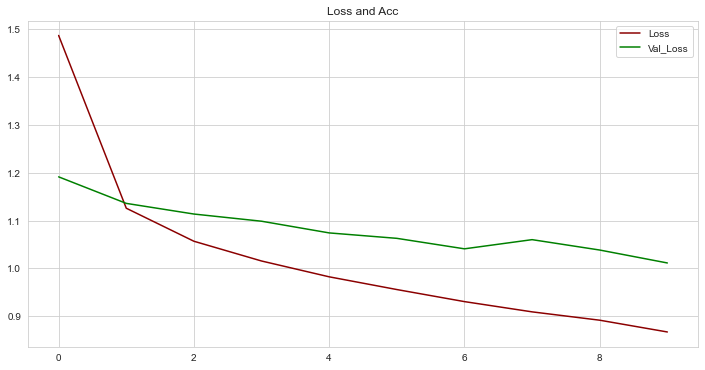

In [24]:
nn_vectorizer(CountVectorizer)

### Utilizando o Tfidf

Epoch 1/15
586/586 [==============================] - 2s 3ms/step - loss: 1.0680 - accuracy: 0.6538 - val_loss: 0.6169 - val_accuracy: 0.8309
Epoch 2/15
586/586 [==============================] - 1s 2ms/step - loss: 0.4072 - accuracy: 0.8896 - val_loss: 0.5617 - val_accuracy: 0.8261
Epoch 3/15
586/586 [==============================] - 1s 3ms/step - loss: 0.2399 - accuracy: 0.9349 - val_loss: 0.5571 - val_accuracy: 0.8430
Epoch 4/15
586/586 [==============================] - 2s 3ms/step - loss: 0.1923 - accuracy: 0.9526 - val_loss: 0.5831 - val_accuracy: 0.8370
Epoch 5/15
586/586 [==============================] - 1s 2ms/step - loss: 0.1730 - accuracy: 0.9573 - val_loss: 0.6063 - val_accuracy: 0.8273
Epoch 6/15
586/586 [==============================] - 1s 2ms/step - loss: 0.1666 - accuracy: 0.9562 - val_loss: 0.6355 - val_accuracy: 0.8237
Epoch 7/15
586/586 [==============================] - 1s 2ms/step - loss: 0.1650 - accuracy: 0.9560 - val_loss: 0.6351 - val_accuracy: 0.8285
Epoch 

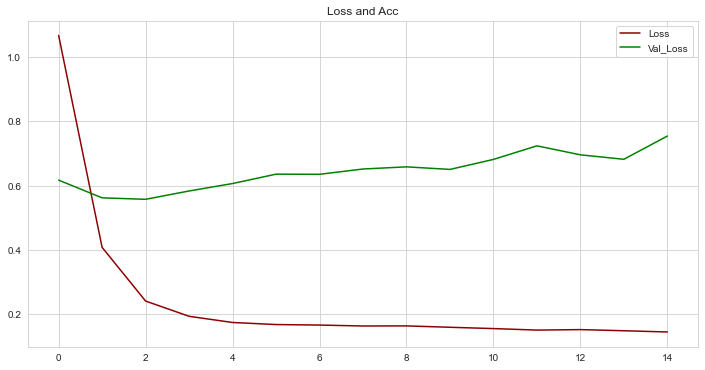

In [25]:
nn_vectorizer(TfidfVectorizer, epochs=15, batch_size=8, h=0.0001)

### Embeddings

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 85)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 85, 32)            332864    
                                                                 
 lstm (LSTM)                 (None, 85, 16)            3136      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense_6 (Dense)             (None, 6)                 54        
                                                                 
Total params: 336,854
Trainable params: 336,854
Non-trainable params: 0
________________________________________________

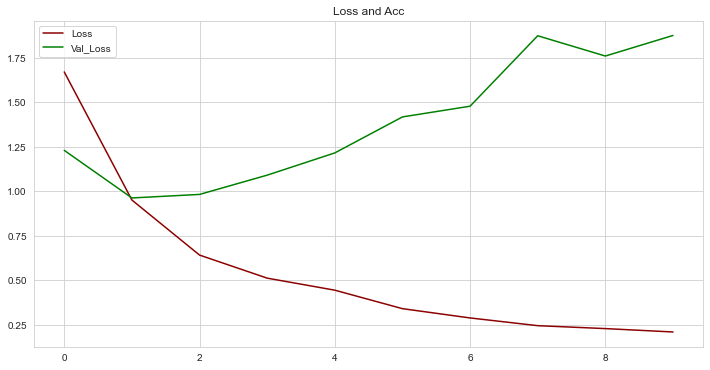

In [26]:
nn_vectorizer(embeddings=True)

## Juntando titulo com o texto

### Bow

Epoch 1/10
586/586 [==============================] - 2s 3ms/step - loss: 1.2702 - accuracy: 0.7513 - val_loss: 1.0351 - val_accuracy: 0.8551
Epoch 2/10
586/586 [==============================] - 2s 3ms/step - loss: 0.9785 - accuracy: 0.8574 - val_loss: 0.9993 - val_accuracy: 0.8587
Epoch 3/10
586/586 [==============================] - 2s 3ms/step - loss: 0.9421 - accuracy: 0.8672 - val_loss: 0.9941 - val_accuracy: 0.8502
Epoch 4/10
586/586 [==============================] - 2s 3ms/step - loss: 0.9129 - accuracy: 0.8753 - val_loss: 0.9945 - val_accuracy: 0.8490
Epoch 5/10
586/586 [==============================] - 2s 3ms/step - loss: 0.8726 - accuracy: 0.8794 - val_loss: 0.9867 - val_accuracy: 0.8527
Epoch 6/10
586/586 [==============================] - 2s 3ms/step - loss: 0.8669 - accuracy: 0.8820 - val_loss: 0.9222 - val_accuracy: 0.8744
Epoch 7/10
586/586 [==============================] - 2s 3ms/step - loss: 0.8464 - accuracy: 0.8818 - val_loss: 0.9666 - val_accuracy: 0.8684
Epoch 

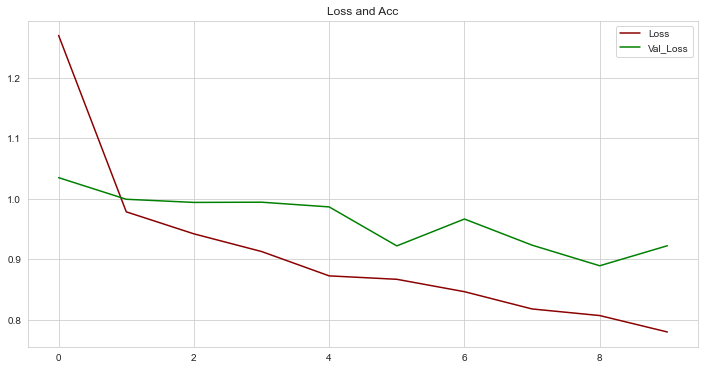

In [20]:
nn_vectorizer(CountVectorizer, batch_size=8, column='Joined')

### Tfidf

Epoch 1/15
781/781 [==============================] - 3s 3ms/step - loss: 1.6867 - accuracy: 0.5016 - val_loss: 1.5172 - val_accuracy: 0.6606
Epoch 2/15
781/781 [==============================] - 2s 3ms/step - loss: 1.4805 - accuracy: 0.6758 - val_loss: 1.3998 - val_accuracy: 0.6896
Epoch 3/15
781/781 [==============================] - 2s 2ms/step - loss: 1.3826 - accuracy: 0.7014 - val_loss: 1.3278 - val_accuracy: 0.7234
Epoch 4/15
781/781 [==============================] - 2s 3ms/step - loss: 1.3194 - accuracy: 0.7419 - val_loss: 1.2841 - val_accuracy: 0.7572
Epoch 5/15
781/781 [==============================] - 2s 2ms/step - loss: 1.2789 - accuracy: 0.7665 - val_loss: 1.2460 - val_accuracy: 0.7705
Epoch 6/15
781/781 [==============================] - 2s 2ms/step - loss: 1.2384 - accuracy: 0.7744 - val_loss: 1.1935 - val_accuracy: 0.7862
Epoch 7/15
781/781 [==============================] - 2s 2ms/step - loss: 1.2046 - accuracy: 0.7834 - val_loss: 1.2120 - val_accuracy: 0.7790
Epoch 

C:\Users\Dayvison\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dayvison\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dayvison\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

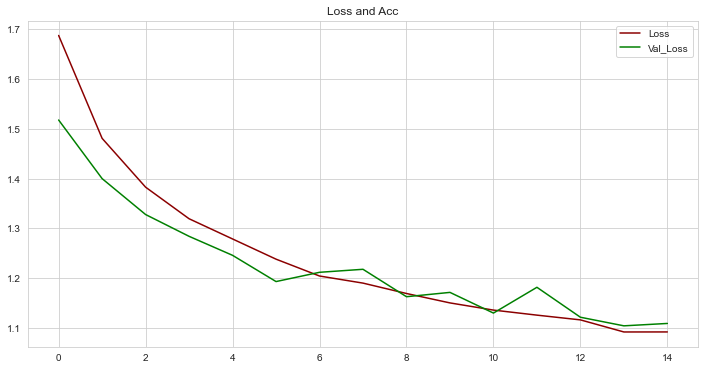

In [21]:
nn_vectorizer(TfidfVectorizer, epochs=15, batch_size=6, column='Joined')

### Embedding

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 135)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 135, 32)           402304    
                                                                 
 lstm_2 (LSTM)               (None, 135, 16)           3136      
                                                                 
 lstm_3 (LSTM)               (None, 8)                 800       
                                                                 
 dense_7 (Dense)             (None, 6)                 54        
                                                                 
Total params: 406,294
Trainable params: 406,294
Non-trainable params: 0
________________________________________________

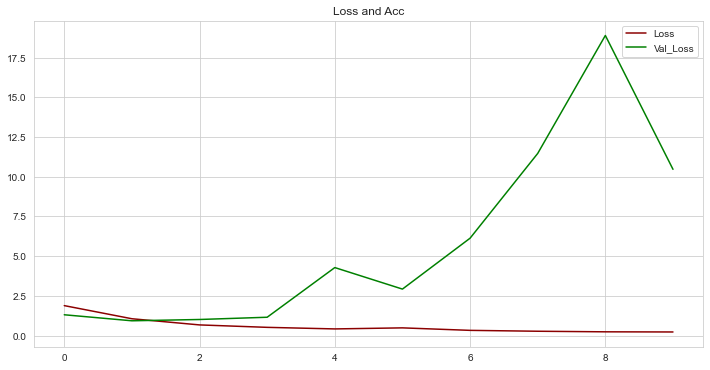

In [23]:
nn_vectorizer(embeddings=True, epochs=10, batch_size=32, column='Joined')

### UnderSampler

In [123]:
columns_train = train.drop(columns=['Category']).columns

In [124]:
rus = RandomUnderSampler(random_state=42)
train, y = rus.fit_resample(train.drop(columns=['Category']).values, train['Category'])


In [125]:
train = pd.DataFrame(train, columns=columns_train)

In [126]:
train['Category'] = y

In [127]:
train

,index,Title,Excerpt,Joined,Category
0,4475,NNPC Pays $452.5m Cash Call Arrears to IOCs in...,nigerian national petroleum company nnpc paid ...,nnpc pays cash call arrears iocs one year nige...,business
1,2958,Nigeria: Dangote Cement Gives Multimillion Nai...,dangote cement awarded multi million naira edu...,nigeria dangote cement gives multimillion nair...,business
2,1571,MTN To Make Up For Network Disruption By Exten...,way paying back network disruption experienced...,mtn make network disruption extending users ti...,business
3,3566,World’s Largest Retailer Walmart Sells Operati...,walmart inc worlds largest retailer said frida...,worlds largest retailer walmart sells operatio...,business
4,2973,South Korea’s LG Pulls Out of Smartphone Busin...,south koreas lg electronics inc wind loss maki...,south koreas lg pulls smartphone business glob...,business
...,...,...,...,...,...
1729,4646,Solar Storm Knocks Out 40 Newly Launched Space...,geomagnetic storm triggered large burst radiat...,solar storm knocks newly launched spacex satel...,tech
1730,4661,Google Announces $1bn Investment in African In...,way giving thousands africans access fast chea...,google announces bn investment african interne...,tech
1731,4671,Italy’s Antitrust Fines Amazon 1.13bn Euros fo...,italys antitrust said thursday fined e commerc...,italys antitrust fines amazon bn euros alleged...,tech
1732,4673,Tesla Takes Another Step to India Launch,tesla moved step closer launch india later yea...,tesla takes another step india launch tesla mo...,tech


In [128]:
train['Category'].value_counts()

business         289
entertainment    289
health           289
politics         289
sports           289
tech             289
Name: Category, dtype: int64

In [129]:
y_train = one.fit_transform(train['Category'].values.reshape(-1,1))

### Bow

Epoch 1/10
1734/1734 [==============================] - 4s 2ms/step - loss: 1.6991 - accuracy: 0.5825 - val_loss: 1.4903 - val_accuracy: 0.7669
Epoch 2/10
1734/1734 [==============================] - 4s 2ms/step - loss: 1.4955 - accuracy: 0.7814 - val_loss: 1.5727 - val_accuracy: 0.7609
Epoch 3/10
1734/1734 [==============================] - 4s 2ms/step - loss: 1.3856 - accuracy: 0.8120 - val_loss: 1.5255 - val_accuracy: 0.7657
Epoch 4/10
1734/1734 [==============================] - 4s 2ms/step - loss: 1.3488 - accuracy: 0.8149 - val_loss: 1.5070 - val_accuracy: 0.7452
Epoch 5/10
1734/1734 [==============================] - 4s 2ms/step - loss: 1.2708 - accuracy: 0.8333 - val_loss: 1.4671 - val_accuracy: 0.7597
Epoch 6/10
1734/1734 [==============================] - 4s 2ms/step - loss: 1.2092 - accuracy: 0.8408 - val_loss: 1.4322 - val_accuracy: 0.7681
Epoch 7/10
1734/1734 [==============================] - 4s 3ms/step - loss: 1.1684 - accuracy: 0.8443 - val_loss: 1.4006 - val_accuracy:

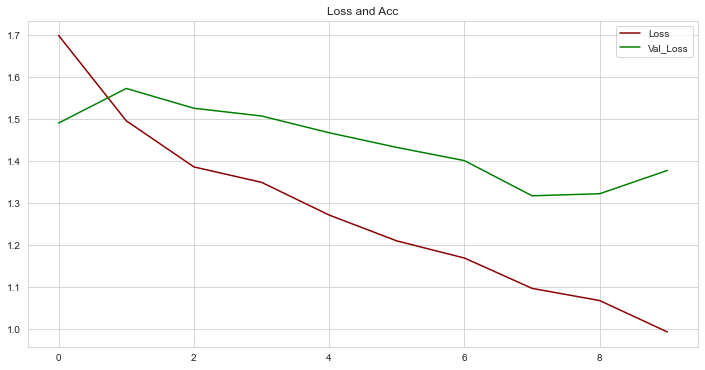

In [132]:
nn_vectorizer(CountVectorizer, epochs=10, batch_size=1)

### Tfidf

Epoch 1/10
1734/1734 [==============================] - 5s 3ms/step - loss: 1.8176 - accuracy: 0.1655 - val_loss: 1.7899 - val_accuracy: 0.2705
Epoch 2/10
1734/1734 [==============================] - 4s 2ms/step - loss: 1.7928 - accuracy: 0.1499 - val_loss: 1.7919 - val_accuracy: 0.1171
Epoch 3/10
1734/1734 [==============================] - 4s 2ms/step - loss: 1.7928 - accuracy: 0.1540 - val_loss: 1.7907 - val_accuracy: 0.2705
Epoch 4/10
1734/1734 [==============================] - 4s 2ms/step - loss: 1.7927 - accuracy: 0.1471 - val_loss: 1.7903 - val_accuracy: 0.2705
Epoch 5/10
1734/1734 [==============================] - 5s 3ms/step - loss: 1.7928 - accuracy: 0.1546 - val_loss: 1.7925 - val_accuracy: 0.1171
Epoch 6/10
1734/1734 [==============================] - 5s 3ms/step - loss: 1.7927 - accuracy: 0.1603 - val_loss: 1.7939 - val_accuracy: 0.1171
Epoch 7/10
1734/1734 [==============================] - 5s 3ms/step - loss: 1.7927 - accuracy: 0.1494 - val_loss: 1.7926 - val_accuracy:

C:\Users\Dayvison\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dayvison\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dayvison\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

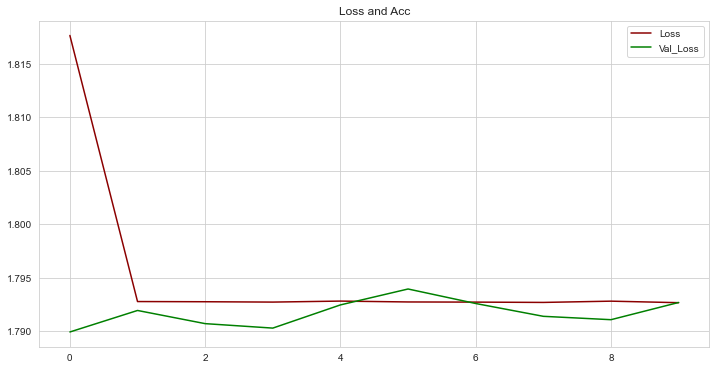

In [133]:
nn_vectorizer(TfidfVectorizer, epochs=10, batch_size=1)

### Embedding

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 121)              0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 121, 32)           206432    
                                                                 
 lstm_6 (LSTM)               (None, 121, 16)           3136      
                                                                 
 lstm_7 (LSTM)               (None, 8)                 800       
                                                                 
 dense_21 (Dense)            (None, 6)                 54        
                                                                 
Total params: 210,422
Trainable params: 210,422
Non-trainable params: 0
________________________________________________

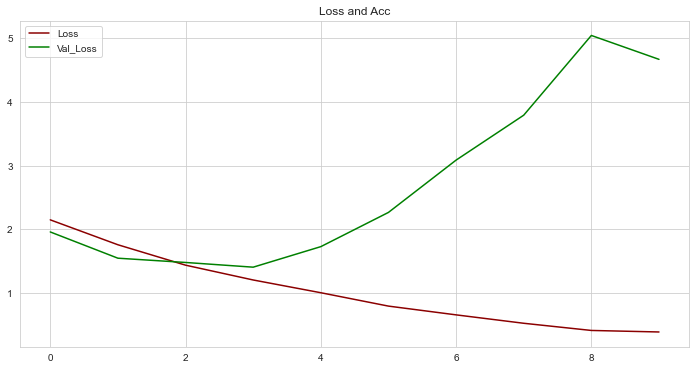

In [135]:
nn_vectorizer(embeddings=True, epochs=10, batch_size=16)

### Data Augmetation

In [110]:
def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

In [111]:
tech = train[train['Category'] == 'tech']
ent = train[train['Category'] == 'entertainment']
health = train[train['Category'] == 'health']

lista_pd = [tech, ent, health]

In [112]:
n_vezes = 2

for i in range(n_vezes):
    cont = 0
    
    for df in lista_pd:
        cont += 1
        
        if i == 1 and cont == 3:
            break
            
        df = df.copy()
        textos = df['Excerpt']
        lista = []
        
        for frase in textos:
            new_frase = synonym_replacement(frase, 2)
            lista.append(new_frase)
            df.loc[len(df)] = ['indice','title', new_frase, df['Category'].iloc[0], 'joined']

        train = pd.concat([train, df])

In [113]:
train

,index,Title,Excerpt,Category,Joined
0,0,"Uefa Opens Proceedings against Barcelona, Juve...",uefa opened disciplinary proceedings barcelona...,sports,uefa opens proceedings barcelona juventus real...
1,1,Amazon Blames Inflation as It Increases Cost o...,increases steeper percent jump prime membershi...,business,amazon blames inflation increases cost prime e...
2,2,Nigeria’s Parliament Passes Amended Electoral ...,nigerias senate tuesday passed harmonised clau...,politics,nigerias parliament passes amended electoral b...
3,3,Nigeria: Lagos Governor Tests Positive for Cov...,lagos state governor mr babajide sanwo olu tes...,health,nigeria lagos governor tests positive covid ka...
4,4,South Africa Calls For Calm as Electoral Refor...,south africa raised concerns deteriorating sit...,politics,south africa calls calm electoral reform prote...
...,...,...,...,...,...
4630,4631,Chimamanda’s Half of a Yellow Sun Voted Best B...,chimamanda ngozi adichies novel half yellow su...,entertainment,chimamandas half yellow sun voted best book wo...
4658,4659,Ghislaine Maxwell Sentenced to 20 Years Over S...,ghislaine maxwell sentenced years us prison he...,entertainment,ghislaine maxwell sentenced years sex traffick...
4675,4676,Netflix’s ‘Bridgerton’ Renewed for Second Season,netflix confirmed renewal acclaimed period dra...,entertainment,netflixs bridgerton renewed second season netf...
4679,4680,Nollywood-Bollywood Collaboration ‘Namaste Wah...,nollywood bollywood collaboration namaste waha...,entertainment,nollywood bollywood collaboration namaste waha...


<AxesSubplot:xlabel='Category', ylabel='count'>

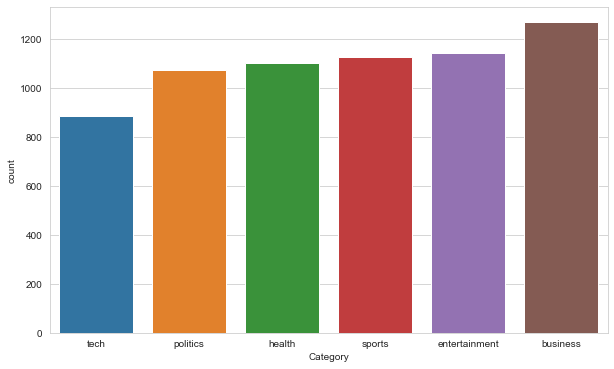

In [114]:
plt.figure(figsize=(10,6))
sns.countplot(x='Category', data=train, order=train['Category'].value_counts(ascending=True).index)

### Bow

In [116]:
y_train = one.fit_transform(train['Category'].values.reshape(-1,1))
y_test = one.transform(test['Category'].values.reshape(-1,1))

Epoch 1/10
413/413 [==============================] - 5s 4ms/step - loss: 1.4720 - accuracy: 0.7437 - val_loss: 1.2137 - val_accuracy: 0.8261
Epoch 2/10
413/413 [==============================] - 1s 3ms/step - loss: 1.0900 - accuracy: 0.8624 - val_loss: 1.1431 - val_accuracy: 0.8370
Epoch 3/10
413/413 [==============================] - 1s 3ms/step - loss: 1.0182 - accuracy: 0.8740 - val_loss: 1.0904 - val_accuracy: 0.8394
Epoch 4/10
413/413 [==============================] - 1s 3ms/step - loss: 0.9713 - accuracy: 0.8806 - val_loss: 1.0899 - val_accuracy: 0.8357
Epoch 5/10
413/413 [==============================] - 2s 4ms/step - loss: 0.9384 - accuracy: 0.8843 - val_loss: 1.0651 - val_accuracy: 0.8333
Epoch 6/10
413/413 [==============================] - 1s 3ms/step - loss: 0.9090 - accuracy: 0.8868 - val_loss: 1.0598 - val_accuracy: 0.8333
Epoch 7/10
413/413 [==============================] - 1s 3ms/step - loss: 0.8893 - accuracy: 0.8916 - val_loss: 1.0530 - val_accuracy: 0.8285
Epoch 

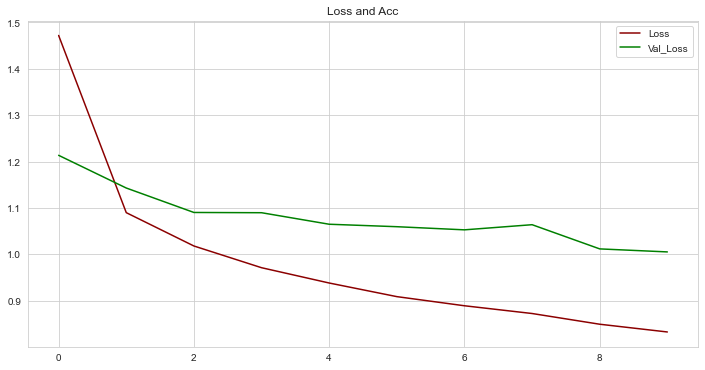

In [117]:
nn_vectorizer(CountVectorizer, epochs=10, batch_size=16)

### Tfidf

Epoch 1/10
413/413 [==============================] - 2s 3ms/step - loss: 1.8501 - accuracy: 0.4060 - val_loss: 1.6297 - val_accuracy: 0.7476
Epoch 2/10
413/413 [==============================] - 1s 3ms/step - loss: 1.6561 - accuracy: 0.6803 - val_loss: 1.5107 - val_accuracy: 0.8128
Epoch 3/10
413/413 [==============================] - 1s 3ms/step - loss: 1.5347 - accuracy: 0.7576 - val_loss: 1.4627 - val_accuracy: 0.8104
Epoch 4/10
413/413 [==============================] - 1s 3ms/step - loss: 1.4460 - accuracy: 0.8022 - val_loss: 1.3906 - val_accuracy: 0.8273
Epoch 5/10
413/413 [==============================] - 1s 3ms/step - loss: 1.3772 - accuracy: 0.8254 - val_loss: 1.3368 - val_accuracy: 0.8237
Epoch 6/10
413/413 [==============================] - 1s 3ms/step - loss: 1.3129 - accuracy: 0.8427 - val_loss: 1.3153 - val_accuracy: 0.8200
Epoch 7/10
413/413 [==============================] - 1s 3ms/step - loss: 1.2740 - accuracy: 0.8511 - val_loss: 1.3166 - val_accuracy: 0.8176
Epoch 

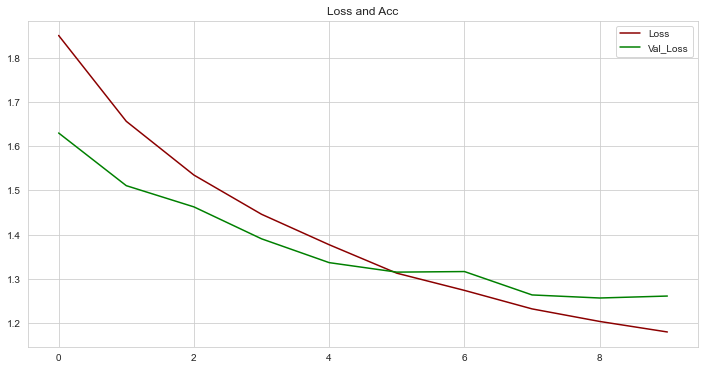

In [118]:
nn_vectorizer(TfidfVectorizer, epochs=10, batch_size=16)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 85)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 85, 32)            333792    
                                                                 
 lstm_2 (LSTM)               (None, 85, 16)            3136      
                                                                 
 lstm_3 (LSTM)               (None, 8)                 800       
                                                                 
 dense_10 (Dense)            (None, 6)                 54        
                                                                 
Total params: 337,782
Trainable params: 337,782
Non-trainable params: 0
________________________________________________

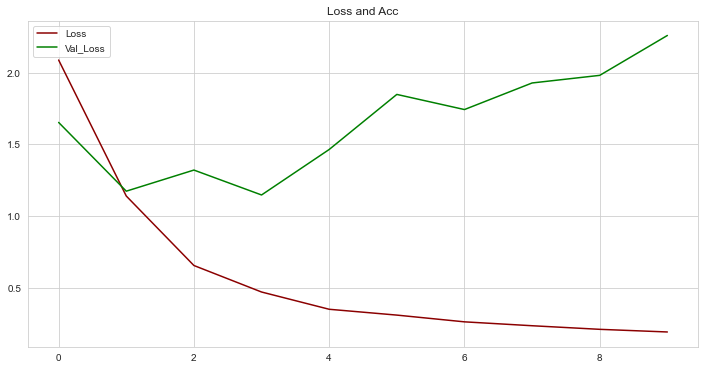

In [121]:
nn_vectorizer(embeddings=True, epochs=10, batch_size=64)